In [1]:
import numpy as np
import tensorflow as tf
import struct as st
import matplotlib.pyplot as plt
import copy
%matplotlib inline
np.set_printoptions(threshold=10)

In [2]:
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.mnist.load_data()

8


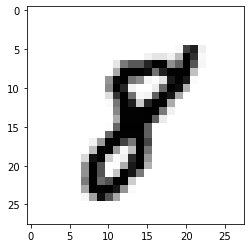

In [3]:
image_index = 17
print(y_train[image_index])
plt.imshow(x_train[image_index],cmap = 'Greys')

In [4]:
x_train_flattened = np.reshape(x_train,(x_train.shape[0],-1))
x_test_flattened = np.reshape(x_test,(x_test.shape[0],-1))
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

In [5]:
x_train_flattened = x_train_flattened.astype('float32')
x_test_flattened = x_test_flattened.astype('float32')
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [6]:
x_train_flattened = x_train_flattened/255
x_test_flattened = x_test_flattened/255
X_train = x_train_flattened.T
X_test = x_test_flattened.T

In [7]:
n_labels = 10
Y_train = np.zeros((n_labels,y_train.shape[0]))
Y_test = np.zeros((n_labels,y_test.shape[0]))

for i in range(len(y_train)):
    Y_train[int(y_train[i])][i] = 1
    
for i in range(len(y_test)):
    Y_test[int(y_test[i])][i] = 1

In [8]:
def relu(z):
    return np.maximum(z,0)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def tanh(z):
    return np.tanh(z)

def atan(z):
    return np.arctan(z)

def softmax(z):
    return np.divide(np.exp(z-np.max(z,axis=0)),np.sum(np.exp(z-np.max(z,axis=0)),axis=0))

In [9]:
def activation_function(z,activation):
    if activation == 'relu':
        return relu(z)
    elif activation == 'tanh':
        return tanh(z)
    elif activation == 'atan':
        return atan(z)
    elif activation == 'sigmoid':
        return sigmoid(z)
    elif activation == 'softmax':
        return softmax(z)

In [38]:
def initialize_parameters(X,nn_architecture,nn_activations,learning_rate,**kwargs):
    cache = {}
    h_params = {'nn_arch': nn_architecture,
                'lr': learning_rate,
                'nn_acti': nn_activations,
                'reg' : kwargs.get('reg',None),
                'lam': kwargs.get('lam',1),
                'kp': kwargs.get('kp',1)}
    W = np.random.rand(nn_architecture[0],X.shape[0]) * 0.01
    B = np.random.rand(nn_architecture[0],1)
    cache.update({'W'+str(0): W, 'B'+str(0):B})
    for i in range(1,len(nn_architecture)):
        W = np.random.rand(nn_architecture[i],nn_architecture[i-1]) * 0.01
        B = np.random.rand(nn_architecture[i],1)
        cache.update({'W'+str(i): W, 'B'+str(i):B})
        
    return cache,h_params

In [54]:
def forward_nn_network(X,cache,h_params):
    A = X
    if h_params['reg'] != 'dropout':
        for i in range(len(h_params['nn_arch'])):
            X = A
            Z = np.matmul(cache['W'+str(i)],X) + cache['B'+str(i)]
            A = activation_function(Z,h_params['nn_acti'][i])
            cache.update({'A'+str(i): A,
                         'Z'+str(i): Z})
    else:
        for i in range(len(h_params['nn_arch'])):
            X = A
            mask = (np.random.standard_normal(cache['W'+str(i)].shape) >= h_params['kp']) * 1
            Z = np.matmul(np.multiply(cache['W'+str(i)],mask),X) + cache['B'+str(i)]
            A = activation_function(Z,h_params['nn_acti'][i]) / (1-h_params['kp'])
            cache.update({'A'+str(i): A,
                         'Z'+str(i): Z,
                         'D'+str(i): mask})
    return A,cache

In [24]:
def cost_function(Y_pred,Y_true,cost):
    if cost == 'mae':
        return 1.0/Y_pred.shape[1] * np.sum(np.abs(Y_pred-Y_true),axis = 1,keepdims = True)
    elif cost == 'mse':
        return 0.5/Y_pred.shape[1] * np.sum((Y_pred-Y_true)**2,axis = 1,keepdims = True)
    elif cost == 'cross-entropy':
        if Y_pred.shape[0] == 2:
            return -1.0/Y_pred.shape[1] * np.sum(np.multiply(Y_true,np.log(Y_pred))+np.multiply((1.0-Y_true),np.log(1.0-Y_pred)),axis = 1, keepdims = True)
        else:
            return -1.0/Y_pred.shape[1] * np.sum(np.multiply(Y_true,np.log(Y_pred)),axis = 1,keepdims = True)

In [25]:
def cost_function_derivative(Y_pred,Y_train,cost):
    if cost == 'mae':
        return 1.0/Y_pred.shape[1]
    elif cost == 'mse':
        return 1.0/Y_pred.shape[1] * (Y_pred - Y_train)
    elif cost == 'cross-entropy':
        if Y_pred.shape[0] == 2:
            return 1.0/Y_pred.shape[1] * np.divide((Y_pred-Y_train),((1-Y_pred)*(Y_pred)))
        else:
            return 1.0/Y_pred.shape[1] * np.divide(Y_train,Y_pred)

In [26]:
def activation_derivative(Z,activation):
    if activation == 'relu':
        return (lambda X: X>=0)(Z) * 1
    elif activation == 'atan':
        return 1.0/(Z**2 +1.0)
    elif activation == 'tanh':
        return 1.0-(tanh(Z))**2
    elif activation == 'sigmoid':
        return np.multiply(sigmoid(Z),1.0-sigmoid(Z))
    elif activation == 'softmax':
        return np.multiply(softmax(Z),np.eye(Z.shape[0])-softmax(Z))

In [61]:
def backward_nn_network(X,Y_pred,Y_true,cost,cache,h_params):
    
    if h_params['reg'] != 'dropout':
        # Obtain the pre-multiplier (also dB)
        if h_params["nn_acti"][-1] == 'softmax' and cost == 'cross-entropy':
            pre_mul = Y_pred-Y_true
        else:
            # First find the derivatives for the cost function
            dJ = cost_function_derivative(Y_pred,Y_true,cost)
            # Then find the activation derivative for the last layer
            dA_dZ = activation_derivative(cache['A'+str(len(h_params['nn_arch'])-1)],h_params['nn_acti'][len(h_params['nn_arch'])-1])
            pre_mul = np.matmul(dJ.T,dA_dZ)

        # Obtain the dW and dB
        dW = np.matmul(pre_mul,cache['A'+str(len(h_params['nn_arch'])-2)].T)
        dB = np.sum(pre_mul,axis=1,keepdims=True)
        # Store it in a cache
        cache.update({'dW'+str(len(h_params['nn_arch'])-1): dW,
                     'dB'+str(len(h_params['nn_arch'])-1): dB})

        # Similarly for the middle layers

        for i in range(len(h_params['nn_arch'])-2,0,-1):
            pre_mul = np.matmul(cache['W'+str(i+1)].T,pre_mul)
            dA_dZ = activation_derivative(cache['A'+str(i)],h_params['nn_acti'][i])
            pre_mul = np.multiply(pre_mul,dA_dZ)
            dW = np.matmul(pre_mul,cache['A'+str(i-1)].T)
            dB = np.sum(pre_mul,axis=1,keepdims=True)
            cache.update({'dW'+str(i): dW,
                         'dB'+str(i): dB})

        # Similarly for the first layer
        pre_mul = np.matmul(cache['W'+str(1)].T,pre_mul)
        dA_dZ = activation_derivative(cache['A'+str(0)],h_params['nn_acti'][0])
        pre_mul = np.multiply(pre_mul,dA_dZ)
        dW = np.matmul(pre_mul,X.T)
        dB = np.sum(pre_mul,axis=1,keepdims=True)
        cache.update({'dW'+str(0): dW,
                     'dB'+str(0): dB})
        
        
    else:
        # Obtain the pre-multiplier (also dB)
        if h_params["nn_acti"][-1] == 'softmax' and cost == 'cross-entropy':
            pre_mul = Y_pred-Y_true
        else:
            # First find the derivatives for the cost function
            dJ = cost_function_derivative(Y_pred,Y_true,cost)
            # Then find the activation derivative for the last layer
            dA_dZ = activation_derivative(cache['A'+str(len(h_params['nn_arch'])-1)],h_params['nn_acti'][len(h_params['nn_arch'])-1])
            pre_mul = np.matmul(dJ.T,dA_dZ)

        # Obtain the dW and dB
        dW = np.matmul(pre_mul,cache['A'+str(len(h_params['nn_arch'])-2)].T) / (1-h_params['kp'])
        dB = np.sum(pre_mul,axis=1,keepdims=True)
        # Store it in a cache
        cache.update({'dW'+str(len(h_params['nn_arch'])-1): dW,
                     'dB'+str(len(h_params['nn_arch'])-1): dB})

        # Similarly for the middle layers

        for i in range(len(h_params['nn_arch'])-2,0,-1):
            pre_mul = np.matmul(np.multiply(cache['D'+str(i+1)],cache['W'+str(i+1)]).T,pre_mul)
            dA_dZ = activation_derivative(cache['A'+str(i)],h_params['nn_acti'][i])
            pre_mul = np.multiply(pre_mul,dA_dZ)
            dW = np.matmul(pre_mul,cache['A'+str(i-1)].T) / (1-h_params['kp'])
            dB = np.sum(pre_mul,axis=1,keepdims=True)
            cache.update({'dW'+str(i): dW,
                         'dB'+str(i): dB})

        # Similarly for the first layer
        pre_mul = np.matmul(cache['W'+str(1)].T,pre_mul)
        dA_dZ = activation_derivative(cache['A'+str(0)],h_params['nn_acti'][0])
        pre_mul = np.multiply(pre_mul,dA_dZ)
        dW = np.matmul(pre_mul,X.T) / (1-h_params['kp'])
        dB = np.sum(pre_mul,axis=1,keepdims=True)
        cache.update({'dW'+str(0): dW,
                     'dB'+str(0): dB})
    
    return cache

In [28]:
def update_weights(cache,h_params):
    if h_params['reg'] == None:
        for i in range(len(h_params['nn_arch'])):
            cache['W'+str(i)] -= cache['dW'+str(i)] * h_params['lr']
            cache['B'+str(i)] -= cache['dB'+str(i)] * h_params['lr']
    elif h_params['reg'] == 'L2':
        for i in range(len(h_params['nn_arch'])):
            cache['W'+str(i)] -= (cache['dW'+str(i)] + h_params['lam'] * cache['W'+str(i)]/cache['A0'].shape[1]) * h_params['lr']
            cache['B'+str(i)] -= cache['dB'+str(i)] * h_params['lr']
    elif h_params['reg'] == 'dropout':
        for i in range(len(h_params['nn_arch'])):
            cache['W'+str(i)] -= np.multiply(cache['D'+str(i)],cache['dW'+str(i)]) * h_params['lr']
            cache['B'+str(i)] -= cache['dB'+str(i)] * h_params['lr']
    return cache

In [29]:
def nn_network(X,Y_true,nn_architecture,nn_activations,cost,learning_rate,n_epoch,regularization,lam,keep_probs):
    cache,h_params = initialize_parameters(X,nn_architecture,nn_activations,learning_rate,lam,keep_probs)
    cost = []
    if regularization == None:
        for i in range(n_epoch):
            Y_pred,cache = forward_nn_network(X,cache,h_params,regularization)
            loss = cost_function(Y_pred,Y_true,cost)
            print(np.sum(loss))
            cache = backward_nn_network(X,Y_pred,Y_true,cost,cache,h_params)
            cache = update_weights(cache,h_params)
            cost.append(np.sum(loss))
    elif regularization == 'L2':
        for i in range(n_epoch):
            Y_pred,cache = forward_nn_network(X,cache,h_params,regularization)
            loss = cost_function(Y_pred,Y_true,cost)
            for j in range(len(h_params['nn_arch'])):
                loss += 0.5 * h_params['lam'] * np.sum(np.square(cache['W'+str(j)])) / Y_pred.shape[1]
            print(np.sum(loss))
            cache = backward_nn_network(X,Y_pred,Y_true,cost,cache,h_params)
            cache = update_weights(cache,h_params,regularization)
            cost.append(np.sum(loss))
    elif regularization == 'dropout':
        for i in range(n_epoch):
            Y_pred,cache = forward_nn_network(X,cache,h_params,regularization)
            loss = cost_function(Y_pred,Y_true,cost)
            print(np.sum(loss))
            cache = backward_nn_network(X,Y_pred,Y_true,cost,cache,h_params)
            cache = update_weights(cache,h_params)
            cost.append(np.sum(loss))
            
    return cache,h_params,cost

In [65]:
cache,h_params = initialize_parameters(X_train,[25,10],['sigmoid','softmax'],1e-4,reg = 'dropout',kp = 0.7)
cost = []

In [79]:
for i in range(100):
    Y_pred,cache = forward_nn_network(X_train,cache,h_params)
    loss = cost_function(Y_pred,Y_train,'cross-entropy')
    print(np.sum(loss))
    cache = backward_nn_network(X_train,Y_pred,Y_train,'cross-entropy',cache,h_params)
    cache = update_weights(cache,h_params)
    cost.append(np.sum(loss))

1.7077650782678746
1.918114035293459
1.7588308923593803
2.068988293533276
1.7177449380717187
1.8125111554395354
1.6157331777932524
1.7979730368768847
1.9763448891217936
1.672094062650999
1.722523366497826
1.7636647394997735
1.9535667553283904
2.0724560003384798
1.728716885117035
1.6033189868107456
1.7334027910449699
1.512303816960783
1.9327542398879731
1.7581826749408487
1.6320930742369715
1.9500054326212366
1.8743779607744109
1.9307318673926037
1.7833756351461543
2.0040644828652043
1.8789485818917568
1.6561932205693557
1.7805581094783536
1.7768015058107232
1.5854108655299017
1.7090961200355748
1.7304447726645724
1.8041933100543674
1.7665703432611486
1.717098924322307
2.060102651112225
1.5800464644131444
1.8279949691960429
1.7539888138366717
1.8565525509175556
1.6380727085053857
1.7334944372774173
1.9605729732754429
1.6596388559611257
1.7054342576046604
1.6898820527362521
1.9802285223253562
1.5837693840292972
1.7795834216293047
1.8084911078500572
1.8288056667209764
1.8307545681366868
1

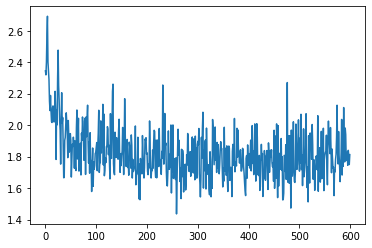

In [80]:
plt.plot(cost)

In [78]:
accuracy_train = (1-(np.sum(np.abs((Y_pred >= np.max(Y_pred,axis=0)) * 1 - Y_train)))/2/Y_train.shape[1]) * 100
print(accuracy_train)

36.934999999999995
